In [1]:
!pip install -q langchain==0.2.16 langchain-community==0.2.16 langchain-huggingface==0.0.3 langchain-text-splitters==0.2.4 chromadb==0.5.3 langchain-chroma==0.1.3 pandas ipywidgets

In [73]:
import pandas as pd
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain_chroma import Chroma
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter
from tqdm import tqdm
import requests
import json

from langchain.chains import StuffDocumentsChain, RetrievalQA, LLMChain, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.document_loaders import TextLoader
from langchain.embeddings import OpenAIEmbeddings, OllamaEmbeddings
from langchain.llms import Ollama, BaseLLM
from langchain.schema import Document, Generation, LLMResult
from langchain.vectorstores import Chroma
from langchain_chroma import Chroma
from langchain_community.llms import OpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_huggingface import HuggingFaceEmbeddings
from pathlib import Path
from tqdm import tqdm
from glob import glob

# Créer et alimenter une base vectorielle

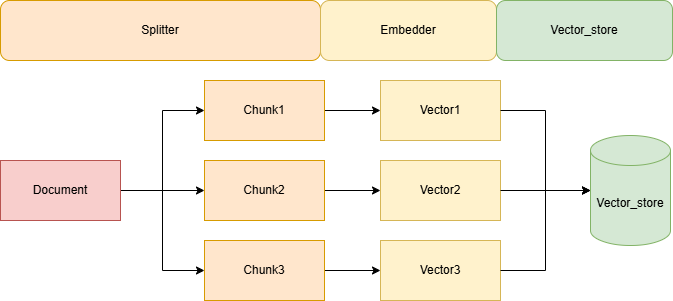

1. CharacterTextSplitter

Classe de LangChain qui découpe un texte selon un caractère de séparation


In [4]:
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ".", " ", ""], #découpe à chaque saut de ligne 
    chunk_size=3000, #taille max d'un chunk = 3000
    chunk_overlap=200, #recouvrement de 200 caractères entre 2 chunks
    length_function=len, #taille du texte
    is_separator_regex=False, #chercher exactement deux sauts de ligne consécutifs (\n\n) pour découper
)

**Si on avait mis is_separator_regex=True ?**

separator="\n\n"  interprété comme un regex ie :

*   "\n{2,}" = deux ou plus sauts de ligne
*  "\s{2,}" = deux ou plus caractères d’espacement, y compris espaces, tabulations, sauts de ligne


* On peut splitter le texte à la main (mais on l'automatisera par la suite)

In [5]:
chunk_text=text_splitter.split_text(TEXT)
chunk_text

['Préambule\n\nEn 2018, MOSS a signé un premier accord relatif au télétravail afin de promouvoir cette nouvelle modalité de travail, moderniser l’organisation du travail, offrir aux salariés une plus grande autonomie dans l’accomplissement de leurs tâches et mieux concilier vie professionnelle et vie personnelle tout en maintenant l’efficacité et la qualité du travail fourni.\n\nEn 2022, un avenant à cet accord initial a été signé afin de poursuivre la direction impulsée quatre ans plus tôt tout en prenant en compte les nouvelles pratiques de télétravail qui ont été grandement bousculées et généralisées par la mise en place du télétravail contraint en conséquence de la crise sanitaire du Covid-19.\n\nA travers le présent accord, fruit de négociations tout au long des mois de septembre à décembre 2023 entre la Direction et les Organisations Syndicales représentatives, MOSS réaffirme sa volonté initiale, élargit et améliore les conditions de réalisation du télétravail. Ces avancées, si e

* Une autre fonction pour créer directement les documents de Langchain qu'on utilisera ensuite

In [6]:
documents_test = text_splitter.create_documents([TEXT])
documents_test

[Document(page_content='Préambule\n\nEn 2018, MOSS a signé un premier accord relatif au télétravail afin de promouvoir cette nouvelle modalité de travail, moderniser l’organisation du travail, offrir aux salariés une plus grande autonomie dans l’accomplissement de leurs tâches et mieux concilier vie professionnelle et vie personnelle tout en maintenant l’efficacité et la qualité du travail fourni.\n\nEn 2022, un avenant à cet accord initial a été signé afin de poursuivre la direction impulsée quatre ans plus tôt tout en prenant en compte les nouvelles pratiques de télétravail qui ont été grandement bousculées et généralisées par la mise en place du télétravail contraint en conséquence de la crise sanitaire du Covid-19.\n\nA travers le présent accord, fruit de négociations tout au long des mois de septembre à décembre 2023 entre la Direction et les Organisations Syndicales représentatives, MOSS réaffirme sa volonté initiale, élargit et améliore les conditions de réalisation du télétrava

Crée une liste d’objets Document au format LangChain. 

Chaque Document contient :

* un champ .page_content = le texte du chunk
* un champ .metadata = pour ajouter des infos (ex. : numéro de page, source...)

C’est ce format qu’on utilisera ensuite pour vectoriser, indexer, ou faire des requêtes.

## 2- Quel embbedding choisir ?

* On réutilise le modèle **BGE-M3** qui donne des bonnes performances pour les textes français, d'après le benchmark de Camille André : https://medium.com/@camille_andre/enhancing-language-model-performance-insights-into-rag-and-chunking-augmentation-techniques-897ba15a04d6

* Pour ne pas télécharger le modèle complet, on utilise ici un modèle plus petit (possibilité de mettre en cache et de charger en cache : exercice)

La fonction **HuggingFaceEmbeddings**de Langchain permet de télécharger le modèle demandé, et on donnera l'embedder par la suite pour vectoriser les chunks

In [7]:
model_kwargs = {'device': 'cuda'} #'cuda' = carte graphique NVIDIA
#model_kwargs = {'device': 'cpu'}  #'cpu' = processeur 
MODEL_NAME_EMBEDDER="BAAI/bge-small-en-v1.5"  #petit modèle en anglais
#MODEL_NAME_EMBEDDER="BAAI/bge-m3" #gros modèle multilingue

embedder = HuggingFaceEmbeddings(
    model_name=MODEL_NAME_EMBEDDER, 
    model_kwargs=model_kwargs,
    show_progress=False
)

In [8]:
embedder.embed_query("Le RAG c'est cool")

[-0.06871248781681061,
 0.01748417690396309,
 0.10688383132219315,
 -0.05092497542500496,
 0.017960602417588234,
 0.006869616452604532,
 0.09712247550487518,
 0.024105850607156754,
 0.059918977320194244,
 -0.04478831589221954,
 -0.009884020313620567,
 -0.028055524453520775,
 0.02010309137403965,
 0.03438934311270714,
 -0.0019689491018652916,
 0.05104025825858116,
 0.08104262501001358,
 0.027935191988945007,
 -0.06532784551382065,
 -0.03590995818376541,
 -0.01726965419948101,
 -0.017351778224110603,
 0.05465973913669586,
 -0.057284798473119736,
 -0.015964781865477562,
 -0.03782418370246887,
 -0.05838398262858391,
 0.03210727497935295,
 -0.06953392177820206,
 -0.08449430763721466,
 0.043898336589336395,
 -0.013127995654940605,
 0.007821070030331612,
 -0.051060229539871216,
 -0.01409050915390253,
 -0.01727602630853653,
 -0.007008497137576342,
 -0.014455596916377544,
 -0.028566507622599602,
 0.008101562038064003,
 0.028263971209526062,
 -0.047182973474264145,
 -0.017754266038537025,
 -0.05

In [9]:
embedder.embed_documents(chunk_text)

[[-0.06206704303622246,
  0.005588980857282877,
  -0.004708487074822187,
  -0.025804219767451286,
  0.04412960633635521,
  -0.008138921111822128,
  0.029565347358584404,
  -0.01041495893150568,
  -0.011792361736297607,
  -0.038885802030563354,
  -0.006096083205193281,
  -0.026219923049211502,
  -0.017148567363619804,
  -0.019851231947541237,
  0.02921253815293312,
  -0.02836519293487072,
  -0.013244790956377983,
  -0.013901138678193092,
  0.00785653106868267,
  0.01905173435807228,
  0.025367964059114456,
  -0.030956976115703583,
  0.006264695432037115,
  0.005064753815531731,
  0.040904879570007324,
  -0.014409835450351238,
  -0.03117435798048973,
  -0.04076102375984192,
  -0.031974874436855316,
  -0.1322435587644577,
  0.010360280983150005,
  0.016290057450532913,
  -0.029348129406571388,
  0.016191545873880386,
  0.03380994871258736,
  0.03427697345614433,
  -0.05477185547351837,
  -0.044097453355789185,
  -0.036635302007198334,
  0.050889525562524796,
  -0.02233329601585865,
  0.03

Avec ces vecteurs, on peut calculer des similarités cosine

Similarité cosinus entre un vecteur de requête (embed_query) et les vecteurs de documents (embed_documents) pour retrouver les morceaux les plus proches sémantiquement d’une question.

👉 C’est le principe du "retrieval" dans le RAG : ne génère pas directement une réponse, mais récupère d’abord les bouts de contexte les plus pertinents.

## 3- Vectorisation

* Nous utilisons ici ChromaDB qui est une base bien documentée par LangChain, on lui donne l'embedder et on indique un endroit pour enregistre la base

In [10]:
vector_store = Chroma(embedding_function=embedder, #embedder à utiliser
                      persist_directory="./chroma_db"  #répertoire pour stocker les données
)

* Donnons nous un base de documents à vectoriser

In [11]:
MA_BASE="echantillon_hs_tt_cet_accords_et_thematiques.parquet"
df=pd.read_parquet(MA_BASE)

In [12]:
df[['HS', 'TT', 'CET']] = df[['HS', 'TT', 'CET']].astype(int)


In [13]:
df

,accorddocx,numdossier_new,HS,CET,TT,titre_accord
0,ACCORD SUR LA MODULATION DU TEMPS DE TRAVAIL\n...,T02618000383,1,0,0,UN ACCORD COLLECTIF PORTANT SUR LA MODULATION ...
1,\n\n\n\n\n\n\n\n\n\nAccord d’entreprise \nRESE...,T09123010010,0,0,1,ACCORD D'ENTRPRISE DU RESEAU COCAGNE
2,\nACCORD D’ENTREPRISE RELATIF A L’AMENAGEMENT ...,T07421003921,1,0,0,ACCORD D'ENTREPRISE RELATIF A L'AMENAGEMENT DU...
3,Accord de substitution à l’accord d’UES\nRelat...,T07521029005,0,0,1,ACCORD DE SUBSTITUTION A L'ACCORD D'UES RELATI...
4,\nACCORD D’ENTREPRISE RELATIF À \nL’ORGANISATI...,T08522007586,0,1,0,UN ACCORD D'ENTREPRISE RELATIF A L'ORGANISATIO...
...,...,...,...,...,...,...
889,"accord d’ENTREPRISE RELATIF À la rémunération,...",T06721008116,1,0,0,"ACCORD D'ENTREPRISE RELATIF A LA REMUNERATION,..."
890,\n\tACCORD D'ENTREPRISE\nRELATIF AU CONTINGENT...,T02520001798,1,0,0,ACCORD D ENTREPRISE RELATIF AU CONTINGENT D HE...
891,Accord Télétravail\n\nENTRE\n\nL’association S...,T02621002869,0,0,1,UN ACCORD RELATIF AU TELETRAVAIL
892,Accord collectif\nrelatif au télétravail \n\n\...,T04920005111,0,0,1,ACCORD COLLECTIF RELATIF AU TELETRAVAIL


In [14]:
"""for index, row in tqdm(df.iterrows(), total=len(df)):  #iteration sur chaque ligne
    text=df.loc[index].accorddocx
    texts = text_splitter.create_documents([text])
    i=0
    for t in texts:
        t.metadata["id"]=f"{index}_{i}"
        t.metadata["index"]=f"{index}"
        vector_store.add_documents([t])
        i+=1
"""

'for index, row in tqdm(df.iterrows(), total=len(df)):  #iteration sur chaque ligne\n    text=df.loc[index].accorddocx\n    texts = text_splitter.create_documents([text])\n    i=0\n    for t in texts:\n        t.metadata["id"]=f"{index}_{i}"\n        t.metadata["index"]=f"{index}"\n        vector_store.add_documents([t])\n        i+=1\n'

In [31]:
for index, row in tqdm(df.iterrows(), total=len(df)): 
    text = row['accorddocx'] 
    numdossier = row['numdossier_new'] 
    texts = text_splitter.create_documents([text])  #découpage du texte en documents
    i = 0
    for t in texts:
        t.metadata["id"] = f"{numdossier}_{i}"  #numéro de dossier et section du texte
        t.metadata["numdossier"] = f"{numdossier}"  
        vector_store.add_documents([t])
        i += 1

100%|██████████| 894/894 [13:59<00:00,  1.07it/s]


In [29]:
# Suppression de tous les documents de la collection
#vector_store.delete_collection() 

* Charger une base vectorielle depuis un répertoire : il suffit de réutiliser la même fonction que précédemment, comme le répertoire est déjà existant, le programme comprendra

In [32]:
vector_store = Chroma(embedding_function=embedder, persist_directory="./chroma_db")

* à partir de cet objet, on peut visualiser quel type d'embeddings a été choisi (embeddings)
* les documents (get)
* calculer des similarités cosine et rechercher (search)

In [33]:
vector_store.embeddings

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': True}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='BAAI/bge-small-en-v1.5', cache_folder=None, model_kwargs={'device': 'cuda'}, encode_kwargs={}, multi_process=False, show_progress=False)

In [34]:
vector_store.get()

{'ids': ['00067c4c-2980-4fc3-bd08-f03a346b9406',
  '000a5460-e048-4e5d-99ca-195f6a19d08d',
  '0018eb68-29f2-4989-a21a-23eeba1e7753',
  '002abbab-72f2-47f9-98ad-1e639acdd7b8',
  '0037b866-8046-4909-8464-2e9a74c6d56e',
  '00450064-3b57-4657-86b8-74576fe4f4b4',
  '0046dbc1-94d1-4bb4-9cc0-88eae6f98796',
  '004e43e0-b582-4645-9ed8-d46bbf2a87e8',
  '0059a009-afa1-4456-83a1-0a6dcbe1f2b8',
  '005d30ee-9933-4330-9074-c7688d9ecbde',
  '0068570f-4869-4f3a-9fd5-579f32c6b9d2',
  '00727cd0-5b49-418d-9fb1-fa571d033f0b',
  '00747c2e-df60-4062-97e8-6fbe6cade54d',
  '0075407a-e731-471e-b572-8963a68fa9d2',
  '008bb041-ba23-4bed-bfb3-ad61e606aa69',
  '00957609-b719-4713-9b44-1d572eefeee5',
  '00a51e70-b2c2-4562-b438-4088c2e2883a',
  '00a87102-7274-42de-8dc2-7c9be60e060c',
  '00a956ec-90c4-4c4c-a2c0-609b830ada16',
  '00b04cf2-94e9-4915-9011-5086c270d1b7',
  '00bef4ad-88d0-407c-82d1-a38c4c302a0d',
  '00c4e8c2-de1a-4f95-9750-a26e850bc0f6',
  '00c52a0e-34ec-4b27-a8b5-44a16d4e20a3',
  '00ca797c-9c51-4bf2-9560-

In [35]:
vector_store.search("télétravail",search_type="similarity")

# ou de manière equivalente
#vector_store2.similarity_search("télétravail")

[Document(metadata={'id': 'T08022003511_11', 'numdossier': 'T08022003511'}, page_content="Le télétravailleur doit informer immédiatement son supérieur et le support informatique en cas de panne, mauvais fonctionnement, détérioration, perte ou vol du matériel mis à sa disposition. Il bénéficie d’une assistance technique particulière à distance en cas de panne ou d’incident survenant sur le matériel mis à sa disposition pour l’exercice de son activité professionnelle en télétravail. Lorsque la résolution de l’incident technique se révèle impossible ou d’une durée telle que le télétravail en serait durablement perturbé, le salarié devra en informer son responsable hiérarchique et s’organiser pour reprendre son activité professionnelle dans les locaux de l’Association le temps que l’incident soit résolu.\n\n5.1 Environnement du télétravailleur\n\nChaque télétravailleur régulier atteste, dans le cadre du formulaire autodiagnostic de demande de passage en télétravail que son lieu de travail 

* on peut créer un objet personnalisé, qui peut par exemple retourner les 10 chunks les plus proches et sur un index particulier (ce qu'on utilisera par la suite)

In [41]:
mon_retriever=vector_store.as_retriever(search_kwargs={
                "k": 10, 
                "filter": {'numdossier': "T08022003511"}
            })

In [42]:
mon_retriever.invoke("télétravail")

[Document(metadata={'id': 'T08022003511_11', 'numdossier': 'T08022003511'}, page_content="Le télétravailleur doit informer immédiatement son supérieur et le support informatique en cas de panne, mauvais fonctionnement, détérioration, perte ou vol du matériel mis à sa disposition. Il bénéficie d’une assistance technique particulière à distance en cas de panne ou d’incident survenant sur le matériel mis à sa disposition pour l’exercice de son activité professionnelle en télétravail. Lorsque la résolution de l’incident technique se révèle impossible ou d’une durée telle que le télétravail en serait durablement perturbé, le salarié devra en informer son responsable hiérarchique et s’organiser pour reprendre son activité professionnelle dans les locaux de l’Association le temps que l’incident soit résolu.\n\n5.1 Environnement du télétravailleur\n\nChaque télétravailleur régulier atteste, dans le cadre du formulaire autodiagnostic de demande de passage en télétravail que son lieu de travail 

# Utiliser un LLM

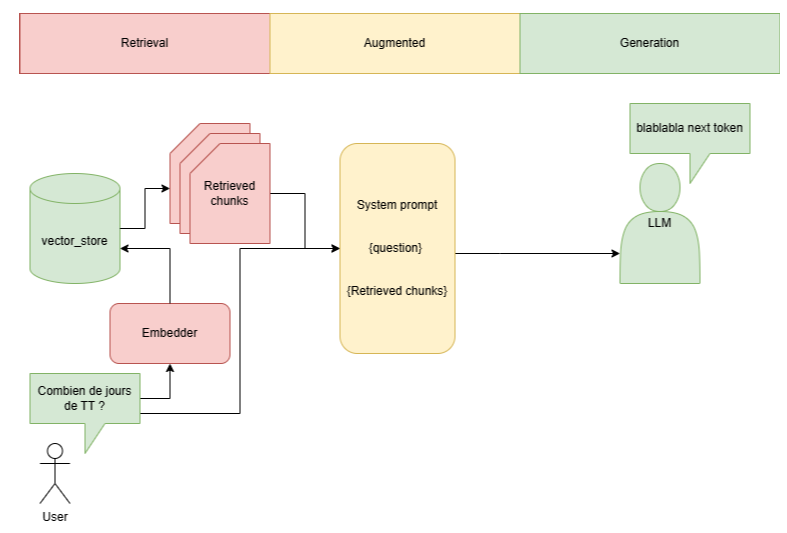

* utilisation de Ollama pour l'installation rapide d'un LLM
* interrogation du LLM en mode API avec des requêtes post/get (mode privilégié pour pouvoir mettre en commun les modèles sous une API)

* installer ollama (faire tourner LLM localement)

In [ ]:
!sudo apt update && sudo apt install --yes lshw
!curl -fsSL https://ollama.com/install.sh | sh

* lancer "ollama serve"
* et lancer "ollama run llama3.1"

classe LangChain personnalisée qui permet d’interagir avec Ollama via API locale

In [63]:
class LocalOllamaLLM(BaseLLM):
    api_url : str
    def _generate(self, prompt, stop):
        response = requests.post(f"{self.api_url}/api/generate", json={"model": "llama3.1", "prompt": str(prompt) })
        response.raise_for_status()
        response_text=''.join([json.loads(line)['response'] for line in response.text.splitlines()])
        generations=[]
        generations.append([Generation(text=response_text)])
        return LLMResult(generations=generations)


    def _llm_type(self):
        return "local"  # Or whatever type is appropriate for your local setup

llm = LocalOllamaLLM(api_url="http://127.0.0.1:11434")

Préparation du prompt 

In [114]:
system_prompt = """
 Vous êtes un statisticien au Ministère du travail. Répondez à la question posées
 Utilisez le contexte (sélection des meilleurs paragraphes liés à la question) donné pour répondre à la question. 
 Si la réponse ne se trouve pas dans le contexte, répondez par 'Je ne sais pas'
 Contexte : {context}
 """

In [115]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

In [116]:
prompt

ChatPromptTemplate(input_variables=['context', 'input'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], template="\n Vous êtes un statisticien au Ministère du travail. Répondez à la question posées\n Utilisez le contexte (sélection des meilleurs paragraphes liés à la question) donné pour répondre à la question. \n Si la réponse ne se trouve pas dans le contexte, répondez par 'Je ne sais pas'\n Contexte : {context}\n ")), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))])

In [117]:
QUESTION="Combien de jour de télétravail par semaine ?"

In [118]:
QUESTION="Qui peut mettre fin au télétravail et sous quelles conditions ?"

In [119]:
QUESTION="Qu'est ce qu'un accord d'entreprise?"

StuffDocumentsChain = méthode simple qui concatène tous les documents trouvés,
et les injecte d’un seul bloc dans le prompt envoyé au LLM. 
D'autres variantes comme map_reduce, refine, map_rerank

In [120]:
question_answer_chain = create_stuff_documents_chain(llm, prompt)

In [121]:
question_answer_chain

RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableLambda(format_docs)
}), config={'run_name': 'format_inputs'})
| ChatPromptTemplate(input_variables=['context', 'input'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], template="\n Vous êtes un statisticien au Ministère du travail. Répondez à la question posées\n Utilisez le contexte (sélection des meilleurs paragraphes liés à la question) donné pour répondre à la question. \n Si la réponse ne se trouve pas dans le contexte, répondez par 'Je ne sais pas'\n Contexte : {context}\n ")), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))])
| LocalOllamaLLM(api_url='http://127.0.0.1:11434')
| StrOutputParser(), config={'run_name': 'stuff_documents_chain'})

In [122]:
retriever=vector_store.as_retriever(
    search_kwargs={
            "k": 5, 
            "filter": {'numdossier': "T08022003511"}
        }
)
chain = create_retrieval_chain(retriever, question_answer_chain)

In [123]:
chain

RunnableBinding(bound=RunnableAssign(mapper={
  context: RunnableBinding(bound=RunnableLambda(lambda x: x['input'])
           | VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x7efc10483200>, search_kwargs={'k': 5, 'filter': {'numdossier': 'T08022003511'}}), config={'run_name': 'retrieve_documents'})
})
| RunnableAssign(mapper={
    answer: RunnableBinding(bound=RunnableBinding(bound=RunnableAssign(mapper={
              context: RunnableLambda(format_docs)
            }), config={'run_name': 'format_inputs'})
            | ChatPromptTemplate(input_variables=['context', 'input'], messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context'], template="\n Vous êtes un statisticien au Ministère du travail. Répondez à la question posées\n Utilisez le contexte (sélection des meilleurs paragraphes liés à la question) donné pour répondre à la question. \n Si la réponse ne se trouve pas dans

In [124]:
result=chain.invoke({"input": QUESTION})

In [125]:
result.keys()

dict_keys(['input', 'context', 'answer'])

In [126]:
result["answer"]

"Un accord d'entreprise est un document qui regroupe les conditions et les règles de travail applicables dans une entreprise. Il s'agit généralement d'une convention collective ou d'un accord collectif signé entre l'employeur (ou l'employeur représentant) et les représentants du personnel, qui définit les droits et obligations des parties prenantes.\n\nDans le texte que vous avez fourni, il semble qu'il s'agisse d'un accord d'entreprise concernant la mise en œuvre du télétravail dans une entreprise. L'accord définit notamment :\n\n* Les conditions d'éligibilité pour passer en télétravail (article 2)\n* La procédure pour demander le télétravail (articles 3 et 4)\n* Les modalités d'organisation du télétravail (article 4)\n* Les règles pour suspendre ou mettre fin au télétravail (article 5)\n\nL'accord d'entreprise a pour but de définir clairement les règles et les conditions de travail pour les salariés qui passent en télétravail, afin d'éviter toute ambiguïté ou litige entre l'employeur

In [133]:
QUESTION = "A combien est fixé le contingent annuel d'heures supplémentaires ?  Lister le(s) artcile(s) qui a permis de répondre à la question."

retriever=vector_store.as_retriever(
    search_kwargs={
            "k": 5
        }
)
chain = create_retrieval_chain(retriever, question_answer_chain)

result=chain.invoke({"input": QUESTION})

result["answer"]

"Le contingent annuel d’heures supplémentaires a été fixé à 350 heures par an et par salarié (Article 3).\n\nVoici la liste des articles qui ont permis de répondre à cette question :\n\n1. Article 2 : DUREE - PRISE D'EFFET\nLe présent accord est conclu pour une durée indéterminée, à compter du 01 janvier 2024.\n\n2. Article 3 : CONTINGENT ANNUEL D'HEURES SUPPLEMENTAIRES\nLe contingent d'heures supplémentaires est fixé à 350 heures par année civile et par salarié."